In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

Helper Cells

End Helper Cells

In [2]:
from transformers import AutoTokenizer, DebertaForSequenceClassification

model_path = "output_split_by_doc_fold_1/checkpoint-22500"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = DebertaForSequenceClassification.from_pretrained(model_path)

/mnt/e/TOM/HUST/20232/rst-relations-labeller/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model.to(torch.device('cuda'))

DebertaForSequenceClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (

Inference

In [4]:
df = pd.read_csv('../Datasets/GUM/rst/total_relations.csv')
print(df.shape)
df.head()

(29339, 5)


,nucleus,satellite,relation,word_count,converted_relation
0,Aesthetic Appreciation and Spanish Art :,Insights from Eye - Tracking,elaboration-additional,14,Elaboration
1,Claire Bailey - Ross claire.bailey-ross@port.a...,Aesthetic Appreciation and Spanish Art : Insig...,organization-heading,755,Textual-Organization
2,Claire Bailey - Ross claire.bailey-ross@port.a...,Andrew Beresford a.m.beresford@durham.ac.uk Du...,joint-list,38,Joint
3,Andrew Beresford a.m.beresford@durham.ac.uk Du...,Daniel Smith daniel.smith2@durham.ac.uk Durham...,joint-list,27,Joint
4,Daniel Smith daniel.smith2@durham.ac.uk Durham...,Claire Warwick c.l.h.warwick@durham.ac.uk Durh...,joint-list,19,Joint


In [5]:
# adding <sep> token between nucleus and satellite
separation_token = "[SEP]"
input_sentences = df.apply(lambda x: ''.join([x['nucleus'], separation_token, x['satellite']]), axis=1)
input_sentences[500]

'Language names are written following the recommendation for the transcription of national languages of Senegal , Decree 2005-981 . [SEP]Names of the villages of Mof-Ávvi are written using the Eegimaa orthography and following the pronunciation of village names by native speakers . '

In [6]:
# get labels, dataset now is (input_sentences, labels)
from sklearn.preprocessing import LabelEncoder

labels = df.converted_relation
le = LabelEncoder()
labels = le.fit_transform(labels)
le.classes_

array(['Attribution', 'Background', 'Cause', 'Condition', 'Contrast',
       'Elaboration', 'Enablement', 'Evaluation', 'Explanation', 'Joint',
       'Manner-Means', 'Same-Unit', 'Summary', 'Temporal',
       'Textual-Organization', 'Topic-Change', 'Topic-Comment'],
      dtype=object)

In [7]:
classes_shorthand = ['Attr', 'Bckg', 'Cause', 'Cond', 'Contst',
       'Elab', 'Enab', 'Eval', 'Expl', 'Joint',
       'M-M', 'S-U', 'Sum', 'Temp',
       'Text-Org', 'T-Chan', 'T-Com']

In [8]:
# merge input sentence and labels onto one list (to form dataset object later)
data = []
for text, label in zip(input_sentences, labels):
    datapoint = {'text': text, 'label': label}
    data.append(datapoint)
data = np.array(data)

In [9]:
# tokenizer
import datasets

def tokenize_function(dataset):
    return tokenizer(dataset["text"], padding=True, truncation=True, return_tensors='pt')

dataset = datasets.Dataset.from_list(list(data))

In [10]:
# split train/test set while preserving class distribution
# access split data like this: for i, (train_index, test_index) in enumerate(sss.split(X, y)):
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import evaluate
from sklearn.metrics import f1_score
 
stk = StratifiedKFold(n_splits=5)
data_split = stk.split(input_sentences, labels)

device = 'cuda'
model.to(device)
model.eval()

metric = evaluate.load('f1')

for i, (train_index, test_index) in enumerate(data_split):
    train_data = data[train_index]
    test_data = data[test_index]

    train_set = datasets.Dataset.from_list(list(train_data))
    test_set = datasets.Dataset.from_list(list(test_data))
    
    preds = []
    with torch.no_grad():
        for item in test_set:
            tokens = tokenizer(item['text'], padding=True, truncation=True, return_tensors='pt').to(device)
            output = model(**tokens)
            logits = torch.Tensor.cpu(output.logits)
            preds.append(int(np.argmax(logits, axis=-1)))

    y_true = [item['label'] for item in test_set]
    print(metric.compute(predictions=preds, references=y_true, average='macro'))

{'f1': 0.7664315804848147}
{'f1': 0.7417511832519392}
{'f1': 0.8949852135770613}
{'f1': 0.8778053682093558}
{'f1': 0.8955563348285631}


In [ ]:
all_scores = f1_score(y_true=y_true, y_pred=preds, average=None)
avg_score = f1_score(y_true=y_true, y_pred=preds, average='macro')
avg_score

0.7044898744128532

<BarContainer object of 17 artists>

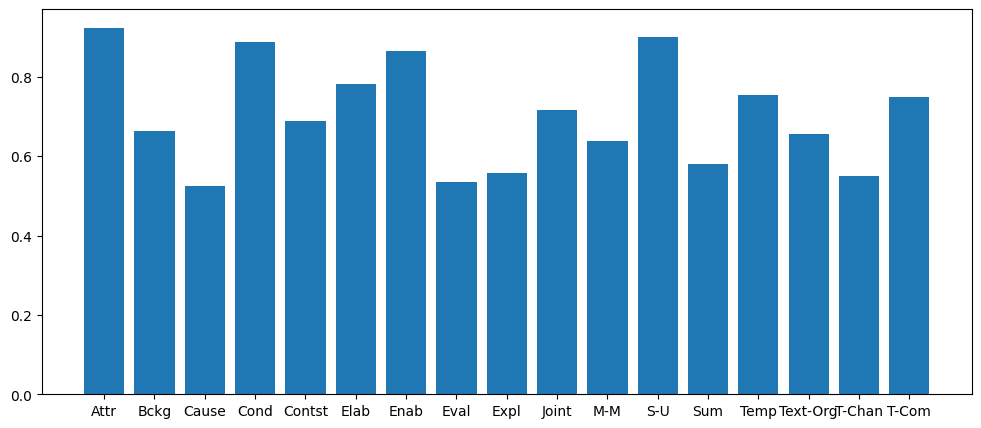

In [259]:
plt.figure(figsize=(12, 5))
plt.bar(classes_shorthand, all_scores)

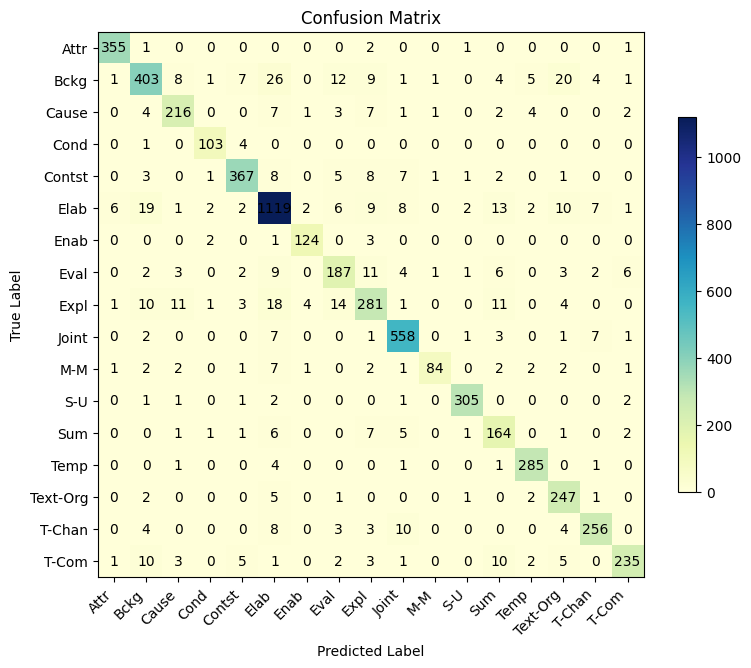

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))  # Adjust figure size as needed
plt.imshow(cm, interpolation='nearest', cmap="YlGnBu")  # Choose your preferred colormap
plt.colorbar(shrink=0.5)
plt.xticks(range(len(set(y_true))), classes_shorthand, rotation=45, ha="right")  # Adjust for many labels
plt.yticks(range(len(set(y_true))), classes_shorthand)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Add text with counts to each cell
for i in range(len(cm)):
  for j in range(len(cm[0])):
    plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [262]:
s_re = 'Cause'
for i in range(700, 708):
    print('_!', df[df['converted_relation'] == s_re].iloc[i, 0], '!_', sep='')
    print('_!', df[df['converted_relation'] == s_re].iloc[i, 1], '!_', sep='')
    print('_!', df[df['converted_relation'] == s_re].iloc[i, 2], '!_', sep='')
    print('_!', df[df['converted_relation'] == s_re].iloc[i, 4], '!_', sep='')
    print()

_!Really , it takes quite an effort to not roll my eyes and tell them to move on !_
_!because I 've got more work prioritised than automating something that does n't even take a wink . !_
_!causal-cause!_
_!Cause!_

_!I do nt have the time to learn how to do that ' . !_
_!that ' i m not a computer person . !_
_!causal-cause!_
_!Cause!_

_!I worked at a call center and some people are really lax about their information and expect other to be lax about their info as well . I 'd have conversations that would go like this : Me : " Ok , I 'm ready for your card number . " Customer : " Well , just use the one I used last time . " Me : " I 'm sorry , I do n't have access to your card number . " Customer : " I do n't understand ... I know you have it right in front of you . " Me : " I can only see the last four digits for security purposes . " Customer : " Well I do n't have my card on me right now ... I just do n't understand why you ca n't use the card I used before . " !_
_!I had people can

Inference

In [8]:
sample_n = """the person looked extremely unwell """
sample_s = """so we stepped a way from him.""" 
sample = sample_n + separation_token + sample_s

with torch.no_grad():
    tokens = tokenizer(sample, padding=True, truncation=True, return_tensors='pt').to(device)
    output = model(**tokens)
    
logits = output.logits
logits = torch.Tensor.cpu(logits)
prediction = int(np.argmax(logits))
label = le.inverse_transform([prediction])
print("Sentence:", sample)
print("Label:", label[0])  

NameError: name 'device' is not defined

In [28]:
# check for <unk> tokens
ids = torch.Tensor.cpu(tokens.input_ids)
word_tokens = tokenizer.convert_ids_to_tokens(np.array(ids)[0])
for tok in word_tokens:
    if tok == tokenizer.unk_token:
        print("Found unk token!")